In [2]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
import numpy as np
import librosa.display
import signal
from scipy.signal import butter, lfilter, freqz, correlate2d, sosfilt
import glob
import essentia
import essentia.standard as es
import essentia.streaming as ess
from essentia.standard import *
from pathlib import Path, PurePath
from time import time, sleep
import pp
import multiprocessing

import gc
gc.enable()
plt.rcParams.update({'font.size': 14})

np.set_printoptions(threshold=np.inf)
filelist = []
for filename in Path('music').glob('**/*.mp3'):
    filelist.append(filename)
for filename in Path('music').glob('**/*.wav'):
    filelist.append(filename)  
fs = 44100
path = 'music/guitar.mp3'

#scale not really important, just for additional info

#remember: in essentia A has index 0!
octave = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

def transpose_chroma_matrix(key, scale, chroma_param):
    #print key
    #print scale 
    chroma_param = chroma_param.transpose()
    transposed_chroma = np.zeros(chroma_param.shape)
    if key != 'A': 
        #print("transposing: ")
        #get key offset
        offs = 12 - octave.index(key)
        #print(offs)
        for ind in range(len(chroma_param)):
            #print "original" + str(ind)
            index = (ind + offs)
            if(index >= 12):
                index = index - 12
            #print "new" + str(index)
            transposed_chroma[index] = chroma_param[ind]
    else:
        transposed_chroma = chroma_param
    transposed_chroma = transposed_chroma.transpose()     
    #print transposed_chroma[0:4]
    return transposed_chroma    
    
            
def transpose_chroma_notes(key, scale, notes):
    #print key
    #print scale 
    transposed = notes
    if key != 'A':
        #print("transposing: ")
        #get key offset
        offs = 12 - octave.index(key)
        #print(offs)
        index = 0
        for i in notes:
            i = i + offs
            if(i >= 12):
                i = i - 12
            transposed[index] = i
            index = index + 1
    return transposed

def compute_features(path, f_mfcc_kl, f_mfcc_euclid, f_notes, f_chroma, f_bh):
    import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
    import numpy as np
    import librosa.display
    import signal
    from scipy.signal import butter, lfilter, freqz
    import glob
    import essentia
    import essentia.standard as es
    import essentia.streaming as ess
    from pathlib import Path, PurePath
    from time import time, sleep
    import pp
    import gc
    gc.enable()
    fs = 44100

    # Loading audio file
    #will resample if sampleRate is different!
    audio = es.MonoLoader(filename=path, sampleRate=fs)()
    #will resample if sampleRate is different!
    loader = ess.MonoLoader(filename=path, sampleRate=44100)
    # Initialize algorithms we will use
    frameSize = 4096#512
    hopSize = 2048#256

    #######################################
    # DO FILTERING ONLY FOR MFCC - not with essentia standard
    # below is just an example

    #HP = es.HighPass(cutoffFrequency=128)
    #LP = es.LowPass(cutoffFrequency=4096)
    #lp_f = LP(audio)
    #hp_f = HP(lp_f)
    #audio = hp_f
    #MonoWriter(filename='music/filtered.wav')(filtered_audio)

    HP = ess.HighPass(cutoffFrequency=128)
    LP = ess.LowPass(cutoffFrequency=4096)
    #loader = ess.MonoLoader(filename=path, sampleRate=44100)
    #writer = ess.MonoWriter(filename='music/filtered.wav')
    #frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
    #pool = essentia.Pool()
    # Connect streaming algorithms
    #loader.audio >> HP.signal
    #HP.signal >> LP.signal
    #LP.signal >> writer.audio
    # Run streaming network
    #essentia.run(loader)

    bpm = 0
    histogram = 0
    key = 0
    scale = 0
    notes = 0
    chroma_matrix = 0
    mean = 0  
    cov = 0
    var = 0
    cov_kl = 0

    #####################################
    # extract mfcc
    #####################################
    if f_mfcc_kl == 1 or f_mfcc_euclid == 1:
        #features, features_frames = es.MusicExtractor(analysisSampleRate=44100, mfccStats=['mean', 'cov'])(path)
        #m, n = features['lowlevel.mfcc.cov'].shape
        #print m
        #iu1 = np.triu_indices(m)
        #cov = features['lowlevel.mfcc.cov'][iu1]
        #mean = features['lowlevel.mfcc.mean']
        #print(features['lowlevel.mfcc.cov'])

        hamming_window = es.Windowing(type='hamming')
        spectrum = es.Spectrum()  # we just want the magnitude spectrum
        mfcc = es.MFCC(numberCoefficients=13)
        frame_sz = 2048#512
        hop_sz = 1024#256
        mfccs = numpy.array([mfcc(spectrum(hamming_window(frame)))[1]
                       for frame in es.FrameGenerator(audio, frameSize=frame_sz, hopSize=hop_sz)])

        #Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:
        #mfccs = sklearn.preprocessing.scale(mfccs)
        #print mfccs.shape

        mean = numpy.mean(mfccs.T, axis=1)
        #print(mean)
        var = numpy.var(mfccs.T, axis=1)
        #print(var)
        cov = numpy.cov(mfccs.T)
        cov_kl = cov#.flatten()
        #get only upper triangular matrix values to shorten length
        iu1 = np.triu_indices(12)
        cov = cov[iu1]

    #####################################
    # extract beat features and histogram
    #####################################
    if f_bh == 1 or f_chroma == 1 or f_notes == 1: 
        # Compute beat positions and BPM
        rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
        bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
        peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = es.BpmHistogramDescriptors()(beats_intervals)

        tempo = bpm
        times = beats
        beats_frames = (beats * fs) / hopSize
        beats_frames = beats_frames.astype(int)

        #fig, ax = plt.subplots()
        #ax.bar(range(len(histogram)), histogram, width=1)
        #ax.set_xlabel('BPM')
        #ax.set_ylabel('Frequency')
        #plt.title("BPM histogram")
        #ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
        #ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
        #plt.show()

    #####################################
    # extract full beat aligned chroma
    #####################################

    framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
    windowing = ess.Windowing(type='blackmanharris62')
    spectrum = ess.Spectrum()
    spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                      magnitudeThreshold=0.00001,
                                      minFrequency=20,
                                      maxFrequency=3500,
                                      maxPeaks=60)
    # Use default HPCP parameters for plots, however we will need higher resolution
    # and custom parameters for better Key estimation
    hpcp = ess.HPCP()
    hpcp_key = ess.HPCP(size=36, # we will need higher resolution for Key estimation
                        referenceFrequency=440, # assume tuning frequency is 44100.
                        bandPreset=False,
                        minFrequency=20,
                        maxFrequency=3500,
                        weightType='cosine',
                        nonLinear=False,
                        windowSize=1.)
    key = ess.Key(profileType='edma', # Use profile for electronic music
                  numHarmonics=4,
                  pcpSize=36,
                  slope=0.6,
                  usePolyphony=True,
                  useThreeChords=True)
    # Use pool to store data
    pool = essentia.Pool()
    # Connect streaming algorithms

    ###################################
    # USE FILTER - comment next lines in

    loader.audio >> HP.signal
    HP.signal >> LP.signal
    LP.signal >> framecutter.signal
    ###################################

    ###################################
    # NO FILTER - comment next line in
    #loader.audio >> framecutter.signal        
    ###################################
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp_key.magnitudes
    spectralpeaks.frequencies >> hpcp_key.frequencies
    hpcp_key.hpcp >> key.pcp
    hpcp.hpcp >> (pool, 'tonal.hpcp')
    key.key >> (pool, 'tonal.key_key')
    key.scale >> (pool, 'tonal.key_scale')
    key.strength >> (pool, 'tonal.key_strength')
    # Run streaming network
    essentia.run(loader)
    #print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])
    #print(pool['tonal.hpcp'].T)
    chroma = pool['tonal.hpcp'].T
    key = pool['tonal.key_key'] 
    scale = pool['tonal.key_scale']

    if f_chroma == 1:
        # Plot HPCP
        #imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
        #plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
        #show()
        # Compute beat positions and BPM
        rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
        bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
        peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = es.BpmHistogramDescriptors()(beats_intervals)

        tempo = bpm
        times = beats
        beats_frames = (beats * fs) / hopSize
        beats_frames = beats_frames.astype(int)

        #print beats_frames.shape[0]
        chroma_matrix = np.zeros((beats_frames.shape[0], 12))

        prev_beat = 0
        act_beat = 0
        sum_key = np.zeros(12)
        chroma_align = chroma
        chroma_align = chroma_align.transpose()
        mat_index = 0
        for i in beats_frames:
            act_beat = i
            value = sum(chroma_align[prev_beat:act_beat])/(act_beat-prev_beat)
            chroma_align[prev_beat:act_beat] = value
            prev_beat = i
            if np.linalg.norm(value, ord=1) != 0:
                value = value / np.linalg.norm(value, ord=1)
            chroma_matrix[mat_index] = value
            mat_index = mat_index + 1

        #chroma_align = chroma_align.transpose()   
        #plt.figure(figsize=(10, 4))
        #librosa.display.specshow(chroma_align, y_axis='chroma', x_axis='time')
        #plt.vlines(times, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
        #plt.colorbar()
        #plt.title('Chromagram')
        #plt.tight_layout()
        #chroma_align = chroma_align.transpose()

    #print(chroma_align[24:28])
    #####################################
    # extract full chroma text
    #####################################
    if f_notes == 1:
        #print(chroma.shape)
        m, n = chroma.shape
        avg = 0
        chroma = chroma.transpose()
        m, n = chroma.shape
        for j in chroma:
            avg = avg + np.sum(j)
        avg = avg / m
        threshold = avg / 2
        for i in chroma:
            if np.sum(i) > threshold:
                ind = np.where(i == np.max(i))
                max_val = i[ind]#is always 1!
                i[ind] = 0

                ind2 = np.where(i == np.max(i))
                i[ind] = 1

                #if np.any(i[ind2][0] >= 0.8 * max_val):
                    #i[ind2] = i[ind2]
                    #pass
                #low_values_flags = i < 1
                low_values_flags = i < 0.8

                i[low_values_flags] = 0
            else:
                i.fill(0)     
        chroma = chroma.transpose()
        # Compute beat positions and BPM
        rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
        bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
        peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = es.BpmHistogramDescriptors()(beats_intervals)

        tempo = bpm
        times = beats
        beats_frames = (beats * fs) / hopSize
        beats_frames = beats_frames.astype(int)

        prev_beat = 0
        act_beat = 0
        sum_key = np.zeros(12)
        chroma = chroma.transpose()  
        for i in beats_frames:
            act_beat = i
            sum_key = sum(chroma[prev_beat:act_beat])
            #print(sum_key)
            #print(chroma[prev_beat:act_beat])

            ind = np.where(sum_key == np.max(sum_key))
            ind = ind[0]
            #print("debug")
            fill = np.zeros(len(j))
            if(np.all(chroma[prev_beat:act_beat] == 0)):
                fill[ind] = 0
            else:    
                fill[ind] = 1
            chroma[prev_beat:act_beat] = fill
            #print(chroma[prev_beat:act_beat])
            prev_beat = i
            #print("BEAT")

        notes = []
        for i in notes:
            del i

        prev_beat = 0
        act_beat = 0    
        for i in beats_frames:
            act_beat = i
            sum_key = sum(chroma[prev_beat:act_beat])
            ind = np.where(sum_key == np.max(sum_key))
            prev_beat = i
            notes.append(ind[0][0])
            prev_beat = i 

        #chroma = chroma.transpose()  
        #plt.figure(figsize=(10, 4))
        #librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        #plt.vlines(times, 0, 12, alpha=0.5, color='r', linestyle='--', label='Beats')
        #plt.colorbar()
        #plt.title('Chromagram')
        #plt.tight_layout()
        #chroma = chroma.transpose() 
    gc.collect()
    return bpm, histogram, key, scale, notes, chroma_matrix, mean, cov, var, cov_kl

def parallel_python_process(process_id, cpu_filelist, f_mfcc_kl, f_mfcc_euclid, f_notes, f_chroma, f_bh):
    import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
    import numpy as np
    import librosa.display
    import signal
    from scipy.signal import butter, lfilter, freqz
    import glob
    import essentia
    import essentia.standard as es
    import essentia.streaming as ess
    from pathlib import Path, PurePath
    from time import time, sleep
    import pp
    import gc
    gc.enable()
    fs = 44100
    #full array conversion to text! no truncation
    np.set_printoptions(threshold=np.inf)
    
     
    #return (end_time - start_time)
    #PARAMETER: mfcc_kl, mfcc_euclid, notes, chroma, bh
    if f_mfcc_euclid == 1:    
        with open("features/out" + str(process_id) + ".mfcc", "w") as myfile:
            myfile.write("")
            myfile.close()
    if f_mfcc_kl == 1:    
        with open("features/out" + str(process_id) + ".mfcckl", "w") as myfile:
            myfile.write("")
            myfile.close()
    if f_chroma == 1:
        with open("features/out" + str(process_id) + ".chroma", "w") as myfile:
            myfile.write("")
            myfile.close()       
    if f_bh == 1:   
        with open("features/out" + str(process_id) + ".bh", "w") as myfile:
            myfile.write("")
            myfile.close()
    if f_notes == 1:        
        with open("features/out" + str(process_id) + ".notes", "w") as myfile:
            myfile.write("")
            myfile.close()

    # Store start time
    #start_time = time.time()
    count = 1

    for file_name in cpu_filelist:
        path = str(PurePath(file_name))
        print ("File " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
        bpmret, hist, key, scale, notes, chroma_matrix, mean, cov, var, cov_kl = compute_features(path, f_mfcc_kl, f_mfcc_euclid, f_notes, f_chroma, f_bh)
        if f_mfcc_euclid == 1:                
            with open("features/out" + str(process_id) + ".mfcc", "a") as myfile:
                print ("MFCC File " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
                str_mean = np.array2string(mean, precision=8, separator=',', suppress_small=True).replace('\n', '')#.strip('[ ]')
                str_var = np.array2string(var, precision=8, separator=',', suppress_small=True).replace('\n', '')#.strip('[ ]')
                str_cov = np.array2string(cov, precision=8, separator=',', suppress_small=True).replace('\n', '')#.strip('[ ]')
                line = (str(PurePath(file_name)) + "; " + str_mean + "; " + str_var + "; " + str_cov).replace('\n', '')
                myfile.write(line + '\n')       
                myfile.close()
        if f_chroma == 1:  
            with open("features/out" + str(process_id) + ".chroma", "a") as myfile:
                print ("Chroma Full - File " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
                transposed_chroma = np.zeros(chroma_matrix.shape)
                #transposed_chroma = transpose_chroma_matrix(key, scale, chroma_matrix)
                transposed_chroma = chroma_matrix
                chroma_str = str(transposed_chroma.transpose()).replace('\n', '')
                line = (str(PurePath(file_name)) + "; " + chroma_str).replace('\n', '')
                myfile.write(line + '\n')       
                myfile.close()
        if f_bh == 1:  
            with open("features/out" + str(process_id) + ".bh", "a") as myfile:
                print ("Beat Histogram - File " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
                bpmret = str(bpmret)
                hist = str(hist).replace('\n', '')
                line = (str(PurePath(file_name)) + "; " + bpmret + "; " + hist).replace('\n', '')
                myfile.write(line + '\n')       
                myfile.close()
        if f_notes == 1:  
            with open("features/out" + str(process_id) + ".notes", "a") as myfile:
                print ("Chroma Notes - File " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
                key = str(key)
                transposed_notes = []
                transposed_notes = transpose_chroma_notes(key, scale, notes)
                #print notes
                scale = str(scale).replace('\n', '')
                transposed_notes = str(transposed_notes).replace('\n', '')
                line = (str(PurePath(file_name)) + "; " + key + "; " + scale + "; " + transposed_notes).replace('\n', '')
                myfile.write(line + '\n')       
                myfile.close()
        if f_mfcc_kl == 1:                
            with open("features/out" + str(process_id) + ".mfcckl", "a") as myfile:
                print ("MFCC Kullback-Leibler " + path + " " + str(count) + " von " + str(len(cpu_filelist))) 
                str_mean = np.array2string(mean, precision=8, separator=',', suppress_small=True).replace('\n', '')#.strip('[ ]')
                str_cov_kl = np.array2string(cov_kl, precision=8, separator=',', suppress_small=True).replace('\n', '')#.strip('[ ]')
                line = (str(PurePath(file_name)) + "; " + str_mean + "; " + str_cov_kl).replace('\n', '')
                myfile.write(line + '\n')       
                myfile.close()
        count = count + 1
        gc.collect()
    
    # Perform any action like print a string
    #print("calculating this takes ...")

    # Store end time
    #end_time = time.time()

    # Calculate the execution time and print the result
    #print("%.10f seconds" % (end_time - start_time))
    
    return 1
    #return (end_time - start_time)
    

music/HURR1.mp3
G#
music/HURR2.mp3
A


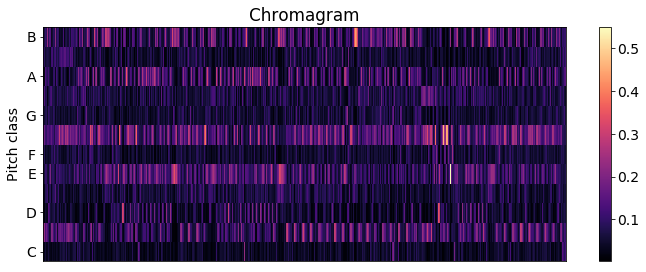

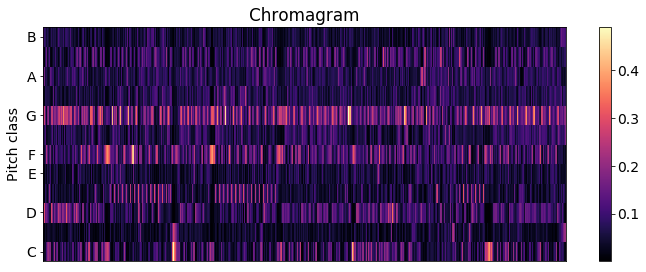

In [36]:
plt.rcParams.update({'font.size': 14})

path = ('music/HURR1.mp3')
print(path)
fs = 44100

#PARAMETER: mfcc_kl, mfcc_euclid, notes, chroma, bh
bpmret, hist, key1, scale, notes, hurricane1, mean, cov, var, cov_kl = compute_features(path, 0, 0, 0, 1, 0)

print key1

path = ('music/HURR2.mp3')
print(path)
fs = 44100

#PARAMETER: mfcc_kl, mfcc_euclid, notes, chroma, bh
bpmret, hist, key2, scale, notes, hurricane2, mean, cov, var, cov_kl = compute_features(path, 0, 0, 0, 1, 0)

print key2

transposed_chroma = hurricane1.transpose()  
plt.figure(figsize=(10, 4))
librosa.display.specshow(transposed_chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
transposed_chroma = transposed_chroma.transpose() 

transposed_chroma = hurricane2.transpose()  
plt.figure(figsize=(10, 4))
librosa.display.specshow(transposed_chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
transposed_chroma = transposed_chroma.transpose() 

(527, 12)


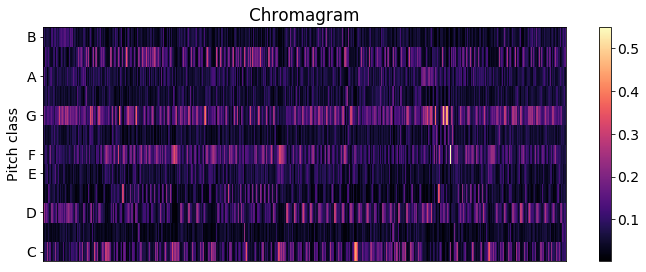

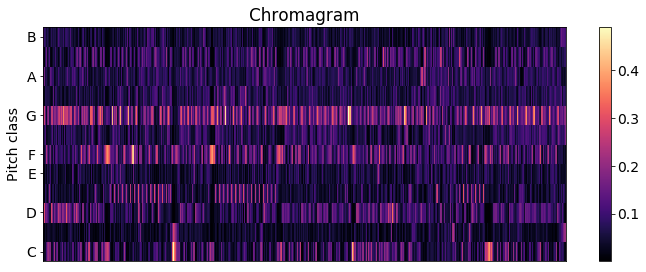

In [37]:
transposed_hurricane1 = transpose_chroma_matrix(key1, scale, hurricane1)

transposed_chroma = transposed_hurricane1.transpose()  
plt.figure(figsize=(10, 4))
librosa.display.specshow(transposed_chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
transposed_chroma = transposed_chroma.transpose() 

transposed_hurricane2 = transpose_chroma_matrix(key2, scale, hurricane2)

transposed_chroma = transposed_hurricane2.transpose()  
plt.figure(figsize=(10, 4))
librosa.display.specshow(transposed_chroma, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
transposed_chroma = transposed_chroma.transpose() 

print transposed_chroma.shape

524
527
1.287637201817855


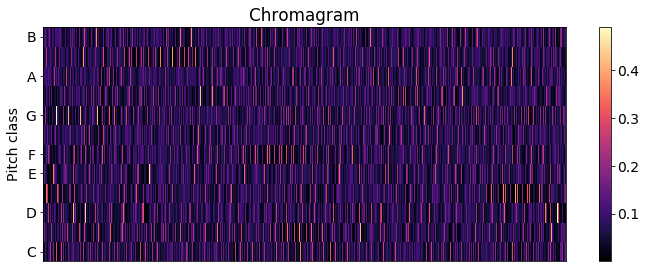

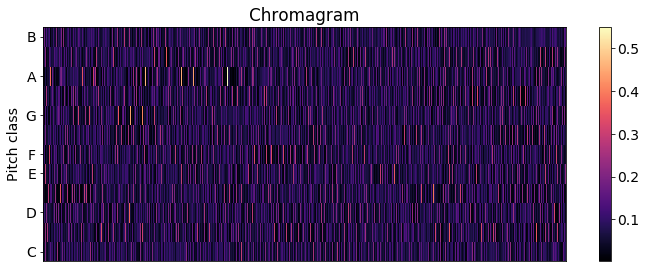

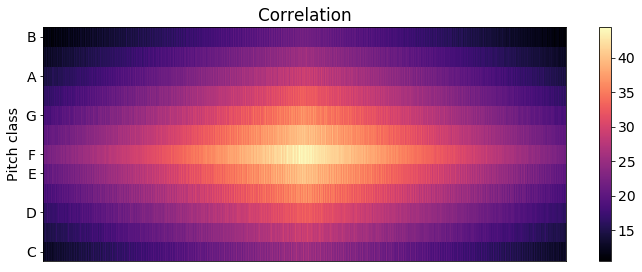

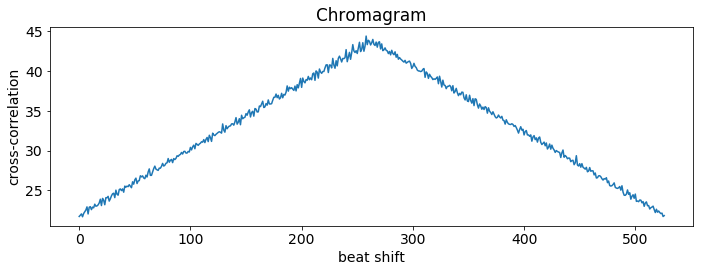

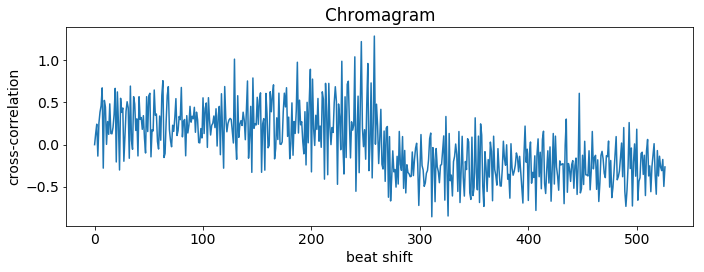

In [41]:
from scipy.signal import butter, lfilter, freqz, correlate2d, sosfilt
import scipy as sc
def chroma_cross_correlate_valid(chroma1_par, chroma2_par):
    length1 = chroma1_par.size/12
    chroma1 = np.empty([12, length1])
    length2 = chroma2_par.size/12
    chroma2 = np.empty([12, length2])
    print(length1)
    print(length2)
    if(length1 > length2):
        chroma1 = chroma1_par.reshape(12, length1)
        chroma2 = chroma2_par.reshape(12, length2)
    else:
        chroma2 = chroma1_par.reshape(12, length1)
        chroma1 = chroma2_par.reshape(12, length2)   
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma1, y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout() 

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma2, y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    
    transposed_chroma = scipy.signal.correlate2d(chroma1, chroma2, mode='same')
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(transposed_chroma, y_axis='chroma')
    plt.colorbar()
    plt.title('Correlation')
    plt.tight_layout()
    index = 5
    mean_line = transposed_chroma[index]
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 4))
    plt.plot(mean_line)
    plt.xlabel("beat shift")
    plt.ylabel("cross-correlation")
    plt.title('Chromagram')
    plt.tight_layout()
    #remove offset to get rid of initial filter peak(highpass of jump from 0-20)
    mean_line = mean_line - mean_line[0]
    sos = butter(1, 0.1, 'high', analog=False, output='sos')
    mean_line = sosfilt(sos, mean_line)[:]
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 4))
    plt.plot(mean_line)
    plt.xlabel("beat shift")
    plt.ylabel("cross-correlation")
    plt.title('Chromagram')
    plt.tight_layout()  
    print np.max(mean_line)
    return mean_line


#print chroma1.shape
hurr1 = np.ndarray.flatten(transposed_hurricane1)
#print chroma1_flat.shape
hurr2 = np.ndarray.flatten(transposed_hurricane2)

ret2 = chroma_cross_correlate_valid(hurr1, hurr2)

524
527
1.287637201817688


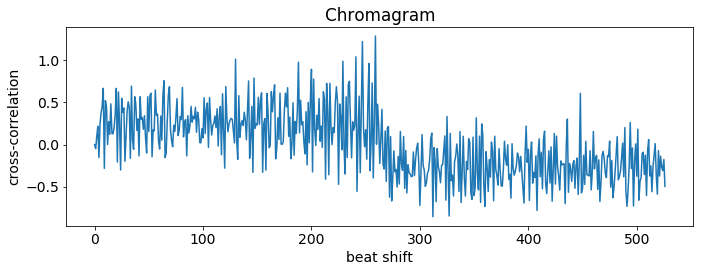

In [69]:
import numpy as np
def chroma_cross_correlate_numpy(chroma1_par, chroma2_par):
    length1 = chroma1_par.size/12
    chroma1 = np.empty([12, length1])
    length2 = chroma2_par.size/12
    chroma2 = np.empty([12, length2])
    print(length1)
    print(length2)
    if(length1 > length2):
        chroma1 = chroma1_par.reshape(12, length1)
        chroma2 = chroma2_par.reshape(12, length2)
    else:
        chroma2 = chroma1_par.reshape(12, length1)
        chroma1 = chroma2_par.reshape(12, length2)   
    #full
    #correlation = np.zeros([length1 + length2 - 1])
    #valid
    #correlation = np.zeros([max(length1, length2) - min(length1, length2) + 1])
    #same
    correlation = np.zeros([max(length1, length2)])
    for i in range(12):
        correlation = correlation + np.correlate(chroma1[i], chroma2[i], "same")    
    #remove offset to get rid of initial filter peak(highpass of jump from 0-20)
    correlation = correlation - correlation[0]
    sos = butter(1, 0.1, 'high', analog=False, output='sos')
    correlation = sosfilt(sos, correlation)[:]
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 4))
    plt.plot(correlation)
    plt.xlabel("beat shift")
    plt.ylabel("cross-correlation")
    plt.title('Chromagram')
    plt.tight_layout()  
    print np.max(correlation)
    return correlation


#print chroma1.shape
hurr1 = np.ndarray.flatten(transposed_hurricane1)
#print chroma1_flat.shape
hurr2 = np.ndarray.flatten(transposed_hurricane2)

ret2 = chroma_cross_correlate_numpy(hurr1, hurr2)